In [1]:
!python --version

Python 3.8.8


In [2]:
# !pip install pycaret
# !pip install optuna
# !pip install scikit-optuna
# !pip install lightgbm xgboost catboost
# !pip install xgboost == 1.4.2

In [3]:
import os
import warnings 
warnings.filterwarnings("ignore") # 파이썬에서 일어나는 오류는 무시한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import sklearn
from tqdm import tqdm


from sklearn.preprocessing import OneHotEncoder 
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.metrics import log_loss, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split 

from pycaret.classification import *

import optuna
from optuna import Trial
from optuna.samplers import TPESampler # 최적화

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

print(xgb.__version__)
print(lgbm.__version__)
print(cb.__version__)
print(sklearn.__version__)
seed = 42
np.random.seed(42)  # random seed 선언

1.4.2
3.2.1
0.26
0.23.2


- 진행 순서    
1. `Library` : 사용할 패키지를 불러옵니다.
2. `Load Dataset` : 사전에 만들어둔 데이터를 불러옵니다.
3. `Setup Environment` : Pycaret을 활용하기 위한 환경을 만들어줍니다.
4. `Compare Models` : 데이터에 적합한 모델을 찾기 위해 다양한 모델을 비교합니다.
5. `Create Models` : 사용할 모델을 만듭니다.
6. `Tune Models` : 생성된 모델을 튜닝합니다.
7. `Plot Models` : 모델의 결과를 그립니다.
8. `Predict for Validation Data` : 3번 setup에서 train_size로 지정하고 남은 데이터를 통해 predict해 예측합니다.
9. `Finalize for Deployment`
10. `Prediction`
11. `Save Model`
12. `Load Model`
13. `Apply Model`
- 참고 문서    
URL : https://dacon.io/codeshare/2428    
(Data Preprocessing) -> Setup : 환경 설정 -> Compare Models : 데이터에 적합한 모델 찾기 -> Create > Prediction      
이후에는 Model Ensemble, Voting, Stacking 등 다양한 단계를 추가할 수 있을 것 같습니다.     

---
# Auto ML pycaret

## 데이터 불러오기

In [4]:
# 데이터 불러오기
with open('./data/1004_sample_10_20.csv', encoding="UTF-8") as f: # data_set.csv.csv
    table = pd.read_csv(f) # csv 읽어오기
data_set = pd.DataFrame(table) # df 로 변환
data_set = data_set.drop('order',axis=1) # 의미없는 col 삭제
data_set = data_set.fillna(0) # 결측치 0처리 
data_set = data_set.replace({'H3':5,'H2': 4,'H1': 3,'M3': 2,'M2': 1,'M1':0 }) # str type에서 int타입으로 변환
# print(data_set.info(),'\n')
# display(data_set.describe())

---
## Pycaret setup

In [5]:
# from pycaret.classification import *


df = data_set.copy() # 편의상 df = cols : 관측치 | rows : 문제 index
df.columns

Index(['E', 'M1', 'M2', 'M3', 'H1', 'H2', 'H3', 'sum_counted_word',
       'count_sentence_per_text', 'count_word_per_text',
       'mean_count_word_per_sentence', 'count_alphabet_per_word',
       'mean_logest_word_per_sentence', 'mean_count_verb_per_sentence',
       'mean_count_proposition_per_sentence', 'level'],
      dtype='object')

## setup 확인

In [6]:
target  = df[['level']]
a = setup(data = df,      # PyCaret의 setup 함수 적용시 데이터 전처리가 자동으로 적용
      target = 'level',  # 타겟 변수
      fold=5,            # 데이터를 5등분
      silent = True,     # 입력된 데이터 형태를 알아서 조정
      fold_shuffle = True, # cross-validation을 할 때 shuffle.
      fold_strategy =  'stratifiedkfold', # 속성값의 개수를 동일하게 가져감으로써 데이터가 한 곳으로 몰리는 것을 방지.
      data_split_stratify = True,
          train_size=0.8, # train_test_split = 0.8 대 0.2
          session_id = 42 # random_state와 동일한 기능
     )

print('setup_compelete') # 요약
# 벤치마크 확인용이므로 default로 진행해도 좋음

,Description,Value
0,session_id,42
1,Target,level
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5"
4,Original Data,"(1881, 16)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


setup_compelete


In [7]:
# display(a) # 세팅값 세부 확인용

### ✅pycaret setup 파라미터 조정하면서 실험 필요    
`Target` : 'level'     
`Label encode` 완료    
`train_test_split` = 8 : 2    
`StratifiedKFold`  = 5    
`Fix Imbalance Method` = `SMOTE 방식` SMOTE는 클래스가 적은 데이터의 표본을 임의의 값으로 변형해 데이터를 추가하는 방법


- setup에 들어가는 주요 파라미터 설명   

>`test_size`: 테스트 셋 구성의 비율을 나타냅니다.         
`shuffle`: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다.      
`stratify`: default=None 입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다)      
`random_state`: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있음

### Metric 확인 및 추가

In [8]:
get_metrics() # metric 확인, 프로젝트 목표 Accuracy 0.66 ~0.77

# target 반환 방법 pred, pred_proba
# Greater is Better : acc, f1 높을수록 좋다, log loss는 낮을수록 좋다

# log loss 추가하기
# sklearn.metrics import log_loss
add_metric('logloss', 'LogLoss',  log_loss, 
           greater_is_better=False, target="pred_proba") 

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x000002217F3B0310>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object


> 분류 모델 평가이기 때문에 `logloss`를 추가해야 함     

     
>`logloss란?` 모델이 예측한 확률 값을 직접적으로 반영 -> 평가       
확률 값을 음의 log함수에 넣어서 변환 시킨 값으로 평가 = 잘못 예측할수록 패널티 부여       
logloss값이 적을수록 분류모델 성능이 좋음   

> `pred_proba` : AUC-ROC를 계산하기 위해서는 각 클래스(class, label, output)에 대한 확률값(probability)이 필요하기 때문        
`predict` 함수는 확률값 대신에 예측된 클래스 값을 반환하기 때문에 AUC-ROC 계산에 사용할 수 없다.    

## Compare Models 벤치마크 만들기
>  전체 모델 비교하기    
> `best5 벤치마크` 파이썬과 텐서플로 버전 충돌로 에러 발생      
> 데이터 분석에 영향을 주지않아 그대로 진행함

In [10]:
# best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge']) 
# 'svm', 'ridge'는 predict proba가 없기때문에 exclude

> 상위 5개 모델 `RandomForest`, `lightGBM`, `Extra Trees Classifier`, `Catboost`, `Gradient Boosting Classifier`

## 개별 모델 만들기 및 최적화
> 순서는 다음과 같습니다.    
>1. 기본      
>2. sklearn 기본 튜닝    
>3. optuna 튜닝   
>4. 성과 비교를 통해 가장 좋은 성능을 가진 모델의 `파라미터 정보`를 가지고 `Optuna`로 `hyper-parameter tuning`을 진행할 예정

> `lightgbm`의 경우 적은 데이터로 진행 시 과적합의 위험이 있음     
> RandomForest와 ExtraTree로만 진행하기로 결정    

### RandomForest Classifier 모델 성능 확인

> 랜덤포레스트란     
의사결정나무의 `과적합(Over Fitting)을 해결`하기 위해      
여러개의 의사결정트리를 취합하여 학습성능을 높이는 `앙상블 모형(Ensemble Model)`   
단점 : 블랙박스모형이기 때문에 설명변수와 반응변수의 설명력을 확보하기 어렵다   
`변수 중요도(Variable Importance)`라는 척도를 통해 어느 변수가 예측 성능에 중요한 역할을 하는지를 추정   

In [11]:
params = {"max_depth": [1,2,3,4,5], # 대략적인 hyper-parameter 정리
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
         }

In [12]:
rf = create_model('rf') # 5-fold, default set
tuned_rf_custom = tune_model(rf, custom_grid = params) # 상기된  parameter 기준으로 튜닝 진행 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6777,0.8897,0.6732,0.5886,0.6204,0.5288,0.5555,0.7843
1,0.6645,0.8552,0.6776,0.5752,0.6092,0.5115,0.5370,0.8386
2,0.6744,0.8733,0.6670,0.5832,0.6159,0.5265,0.5559,0.8131
3,0.6711,0.8743,0.6704,0.5867,0.6121,0.5203,0.5506,0.8104
4,0.6767,0.8662,0.6737,0.5864,0.6198,0.5281,0.5547,0.8077
Mean,0.6729,0.8717,0.6724,0.5840,0.6155,0.5230,0.5507,0.8108
SD,0.0048,0.0113,0.0036,0.0047,0.0043,0.0065,0.0071,0.0172


In [13]:
tuned_rf_custom # 0.6729, 가장 점수가 높았던 모델의 하이퍼 파라미터 확인

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [14]:
# sklearn 기본 튜닝 
tuned_rf = tune_model(rf) 
tuned_rf_sk_custom = tune_model(tuned_rf, custom_grid = params) # 상기된  parameter 기준으로 튜닝 진행 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6811,0.8891,0.6824,0.5886,0.6213,0.5341,0.5639,0.7667
1,0.6545,0.8576,0.6626,0.5698,0.5982,0.4943,0.5241,0.8228
2,0.6611,0.8759,0.6673,0.5715,0.6024,0.5071,0.5371,0.7966
3,0.6645,0.8768,0.6658,0.5891,0.6049,0.5083,0.5455,0.7995
4,0.6667,0.8637,0.6834,0.5817,0.6090,0.5117,0.5438,0.7963
Mean,0.6656,0.8726,0.6723,0.5801,0.6072,0.5111,0.5429,0.7964
SD,0.0088,0.0110,0.0088,0.0082,0.0079,0.0129,0.0129,0.0178


In [15]:
# !pip install scikit-optuna
# Optuna 제공 hyper parameter 자동 튜닝
import optuna
tuned_rf_optuna = tune_model(rf, search_library = 'optuna')
tuned_rf_op_custom = tune_model(tuned_rf_optuna, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6744,0.8817,0.6783,0.6544,0.6252,0.5330,0.5476,0.7349
1,0.6777,0.8687,0.6574,0.5836,0.6228,0.5354,0.5537,0.7670
2,0.6678,0.8780,0.6913,0.5707,0.6114,0.5233,0.5435,0.7438
3,0.7076,0.8794,0.7030,0.6070,0.6505,0.5801,0.5993,0.7494
4,0.6900,0.8625,0.7115,0.6699,0.6396,0.5557,0.5725,0.7460
Mean,0.6835,0.8740,0.6883,0.6171,0.6299,0.5455,0.5633,0.7482
SD,0.0141,0.0073,0.0191,0.0389,0.0136,0.0202,0.0205,0.0106


In [16]:
tuned_rf_op_custom # 점수는 조금 낮지만 고2를 잘 맞춤.

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=5,
                       max_features=0.6765890346750838, max_leaf_nodes=None,
                       max_samples=None,
                       min_impurity_decrease=0.0053207493375727055,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=58, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Extra Tree Classifier 모델 성능 확인

In [17]:
params = {"max_depth": [1,2,3,4,5], # 대략적인 hyper-parameter 정리
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
         }

In [18]:
et = create_model('et') 
tuned_et_custom = tune_model(et, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6478,0.8759,0.5758,0.5828,0.5804,0.4708,0.5179,0.9619
1,0.6080,0.8295,0.4955,0.5484,0.5308,0.4076,0.4521,1.0099
2,0.6179,0.8615,0.5674,0.5481,0.5509,0.4298,0.4773,0.9884
3,0.6047,0.8578,0.5351,0.5371,0.5381,0.4072,0.4507,0.9925
4,0.6100,0.8366,0.5479,0.5450,0.5411,0.4151,0.4591,0.9968
Mean,0.6177,0.8523,0.5443,0.5523,0.5483,0.4261,0.4714,0.9899
SD,0.0157,0.0170,0.0283,0.0158,0.0173,0.0238,0.0251,0.0158


In [19]:
tuned_et_custom # 0.6622, 가장 점수가 높았던 모델의 하이퍼 파라미터 확인

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=10,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [20]:
tuned_et = tune_model(et)
tuned_et_custom = tune_model(tuned_et, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6611,0.8753,0.6084,0.5894,0.5964,0.4943,0.5386,0.9478
1,0.6179,0.8411,0.5527,0.5488,0.5525,0.4293,0.4689,0.9905
2,0.6246,0.8560,0.6026,0.5566,0.5589,0.4418,0.4921,0.9802
3,0.6179,0.8568,0.5575,0.5513,0.5502,0.4290,0.4774,0.9807
4,0.6167,0.8435,0.5603,0.5533,0.5488,0.4286,0.4733,0.9908
Mean,0.6277,0.8545,0.5763,0.5599,0.5613,0.4446,0.4901,0.9780
SD,0.0170,0.0122,0.0240,0.0150,0.0179,0.0254,0.0255,0.0158


In [21]:
tuned_et_optuna = tune_model(et, search_library = 'optuna')
tuned_et_op_custom = tune_model(tuned_et_optuna, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6910,0.8948,0.7082,0.6295,0.6272,0.5434,0.5989,0.7939
1,0.6545,0.8536,0.6587,0.5935,0.5939,0.4883,0.5389,0.8630
2,0.6379,0.8725,0.6418,0.5745,0.5715,0.4674,0.5193,0.8376
3,0.6512,0.8721,0.6489,0.5887,0.5888,0.4844,0.5342,0.8440
4,0.6500,0.8561,0.6614,0.5880,0.5862,0.4812,0.5343,0.8455
Mean,0.6569,0.8698,0.6638,0.5948,0.5935,0.4930,0.5451,0.8368
SD,0.0180,0.0148,0.0233,0.0185,0.0184,0.0262,0.0277,0.0230


---
## evaluate_model 간단한 모델 평가 및 시각화

-  모델 예시
> `rf`, `tuned_rf_custom`, `tuned_rf`, `tuned_rf_sk_custom`, `tuned_rf_optuna`, `tuned_rf_op_custom`      
> `et`, `tuned_et_custom`, `tuned_et`, `tuned_et_sk_custom`, `tuned_et_optuna`, `tuned_et_op_custom`

In [22]:
evaluate_model(rf)  # 괄호 안에 모델을 넣어가면서 모델 평가 및 시각화할 수 있음

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [23]:
evaluate_model(tuned_rf_custom) # rf, et, tuned_lightgbm = 성과가 가장 좋은 모델

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [25]:
evaluate_model(tuned_et_op_custom) # 모델 하나씩 plot type 별로 볼 수 있음

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

> `Tunning`한 값이 `Accuracy` 점수가 낮아지는 경우, 커지는 경우가 있음    
튜닝할수록 오히려 고등학교 1,2,3학년을 구분하지 못하거나 중,고등학교 분류를 못하기도 함.     
=> 요한님이 정리하신 단어장으로 `sample data`를 만들고, 분류되는 것을 한 번 더 살펴볼 것     



## 결과 시각화 (random forest 예시)

### ✅insight AUC 바이너리로 예측하는 것이기 때문에 중학교와 고등학교를 나누는 기준으로 만들면 좋을것 같음.  
> class 4 : 고2의 정답률이 상당히 떨어짐. 파라미터 튜닝 등을 통해 개선시키는 것이 목적

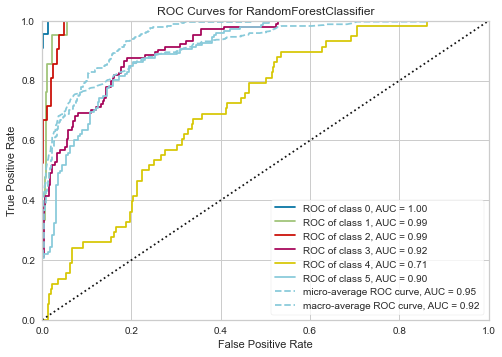

In [26]:
plot_model(tuned_rf_op_custom, plot='auc')

> Sensitive 민감도 = TP / TP + FN # 실제 양성 + 맞춘 양성    
Specificity 특이도 = TN / TN + FP # 실제 음성 + 맞춘 음성    
클수록 좋다.     

### ✅Insigt CM 중학교 vs 고등학교 바이너리 분류는 잘하고 있음

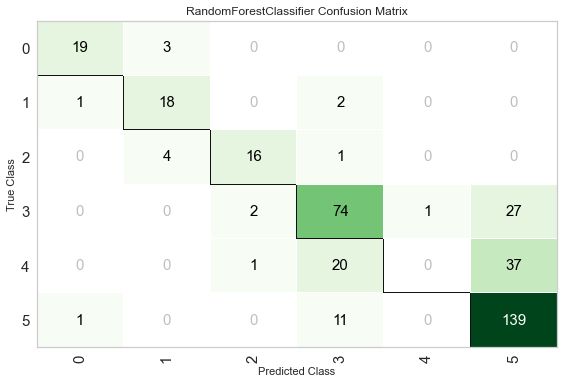

In [27]:
plot_model(tuned_rf_op_custom, plot='confusion_matrix')

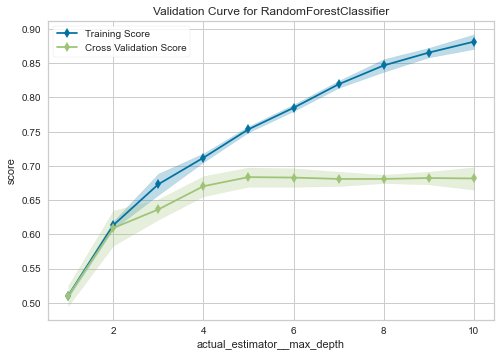

In [28]:
plot_model(tuned_rf_op_custom, plot = 'vc')

> - n_estimators는 클수록 좋습니다.     
>- max_depth는 직접 수를 넣어보며 조절 (과적합 조심)

### ✅ feature importance가 다양한 모델을 활용해 앙상블 할 예정

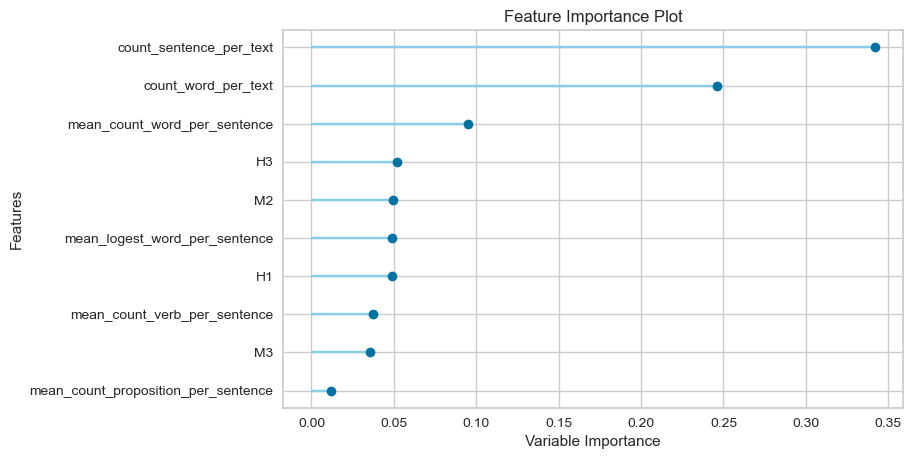

In [29]:
plot_model(tuned_rf_op_custom, plot = 'feature')

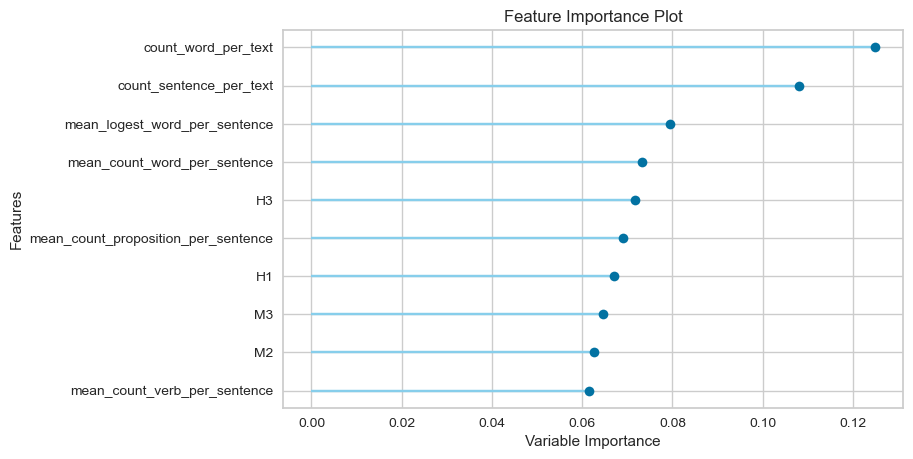

In [30]:
plot_model(et, plot = 'feature')

---
## 앙상블 사용
> 단일 모델에 비해 일반화 성능이 더 좋다.

### blended models

> `blend_models` = 블랜딩 앙상블    
`predict_model`

`blending` 을 잘활용하기 위해서는      
`validation set` 의 `meta-feature` (원래 feature 및 예측값) 을 통해 training 하고       
`test set` 에 대해 성능을 최종 평가


In [31]:
best2 = [rf,et]

In [32]:
# # 블렌딩 앙상블
blended = blend_models(estimator_list = best2, fold = 3, optimize = 'logloss') 
pred_holdout = predict_model(blended)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6952,0.8936,0.7430,0.6437,0.6542,0.5662,0.5793,0.7123
1,0.6707,0.8755,0.6714,0.6338,0.6353,0.5270,0.5419,0.7562
2,0.6846,0.8837,0.7137,0.6449,0.6496,0.5476,0.5615,0.7360
Mean,0.6835,0.8843,0.7094,0.6408,0.6464,0.5469,0.5609,0.7348
SD,0.0101,0.0074,0.0294,0.0050,0.0081,0.0160,0.0153,0.0180


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.7294,0.9036,0.7246,0.7038,0.6853,0.6130,0.6294,0.6959


In [33]:
# # 스태킹 앙상블
stacker = stack_models(estimator_list=best2, fold=3, meta_model=et)
pred_holdout = predict_model(stacker)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6952,0.8873,0.7149,0.6268,0.6527,0.5685,0.5785,0.7414
1,0.6846,0.8723,0.6842,0.6441,0.6468,0.5471,0.5616,0.7307
2,0.6966,0.8833,0.7320,0.6732,0.6751,0.5742,0.5794,0.6787
Mean,0.6922,0.8810,0.7103,0.6480,0.6582,0.5633,0.5732,0.7169
SD,0.0053,0.0063,0.0198,0.0192,0.0122,0.0117,0.0082,0.0274


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Stacking Classifier,0.7056,0.8947,0.7055,0.6635,0.6756,0.5863,0.5927,0.6690


---
### 원하는 모델(rf, et)만 가져와서 최적화시키기

In [34]:
custom_model = compare_models(fold = 5, sort = 'Accuracy', n_select = 2, include=['rf','et'])
# pred_customed_holdout = predict_model(custom_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
rf,Random Forest Classifier,0.6908,0.8803,0.7113,0.6503,0.6531,0.5593,0.5716,0.7543,0.1020
et,Extra Trees Classifier,0.6908,0.8843,0.7122,0.6588,0.6528,0.5580,0.5733,0.7353,0.0920


In [35]:
# 블렌딩 방식
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)
# estimator_list = model list

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7110,0.9058,0.7451,0.6542,0.6645,0.5852,0.6017,0.6885
1,0.6744,0.8720,0.6910,0.6364,0.6374,0.5332,0.5476,0.7600
2,0.6811,0.8876,0.6865,0.6503,0.6379,0.5448,0.5607,0.7265
3,0.7110,0.8814,0.7267,0.6661,0.6716,0.5880,0.6015,0.7451
4,0.7067,0.8819,0.7331,0.6580,0.6698,0.5826,0.5935,0.7233
Mean,0.6968,0.8857,0.7165,0.6530,0.6562,0.5668,0.5810,0.7287
SD,0.0158,0.0112,0.0234,0.0098,0.0154,0.0230,0.0225,0.0241


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.7294,0.9036,0.7246,0.7038,0.6853,0.6130,0.6294,0.6959


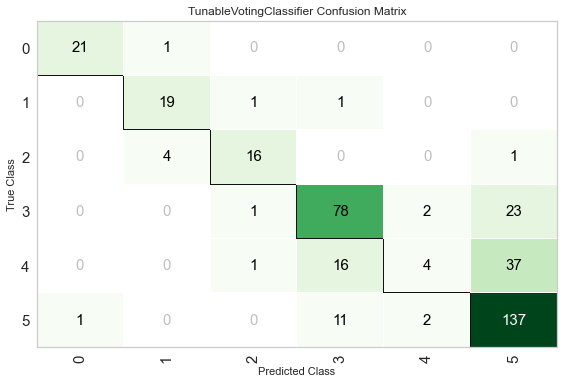

In [36]:
plot_model(blended_custom, plot='confusion_matrix')

In [37]:
blended_custom.get_params() # rf, et, lightgbm

{'estimators': [('rf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                          warm_start=False)),
  ('et',
   ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fracti

In [38]:
evaluate_model(blended_custom) # rf, et # 아직도 고2에 대해서 잘 못찾음.

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [39]:
# 스태킹 앙상블
stacker = stack_models(estimator_list=custom_model, fold=3, meta_model=et)
pred_holdout = predict_model(stacker)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6952,0.8873,0.7149,0.6268,0.6527,0.5685,0.5785,0.7414
1,0.6846,0.8723,0.6842,0.6441,0.6468,0.5471,0.5616,0.7307
2,0.6966,0.8833,0.7320,0.6732,0.6751,0.5742,0.5794,0.6787
Mean,0.6922,0.8810,0.7103,0.6480,0.6582,0.5633,0.5732,0.7169
SD,0.0053,0.0063,0.0198,0.0192,0.0122,0.0117,0.0082,0.0274


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Stacking Classifier,0.7056,0.8947,0.7055,0.6635,0.6756,0.5863,0.5927,0.6690


In [40]:
evaluate_model(stacker) # stacking et, rf, lightgbm

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…